# Nencioli

In [10]:
import pickle
with open('/srv/scratch/z5297792/Sample/U.pkl', 'rb') as file:
    U = pickle.load(file)
with open('/srv/scratch/z5297792/Sample/V.pkl', 'rb') as file:
    V = pickle.load(file)

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time


In [2]:
def nenc_crit_1_2(u, v, a):
    rows_v, cols_v = v.shape
    rows_u, cols_u = u.shape
    if rows_v != rows_u or cols_v != cols_u:
        raise ValueError("The shapes of 'v' and 'u' must be the same.")

    criteria_mask_1 = np.zeros_like(v, dtype=bool)
    criteria_mask_2 = np.zeros_like(u, dtype=bool)

    # First function nenc_crit_1
    for j in range(a, cols_v - a):
        wrk = v[:, j]
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        for ii in indx:
            if ii - a >= 0 and ii + a < rows_v:  # Check boundaries
                if v[ii - a, j] * v[ii + a, j] < 0:
                    if abs(v[ii - a, j]) > abs(v[ii, j]) and abs(v[ii + a, j]) > abs(v[ii, j]):
                        criteria_mask_1[ii, j] = True

    # Second function nenc_crit_2, only checking where criteria_mask_1 is True
    for i in range(a, rows_u - a):
        wrk = u[i, :]
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        for jj in indx:
            if criteria_mask_1[i, jj]:  # Only check where nenc_crit_1 is True
                if jj - a >= 0 and jj + a < cols_u:  # Check boundaries
                    if u[i, jj - a] * u[i, jj + a] < 0:
                        if abs(u[i, jj - a]) > abs(u[i, jj]) and abs(u[i, jj + a]) > abs(u[i, jj]):
                            criteria_mask_2[i, jj] = True

    return criteria_mask_2

def nenc_crit_3(u, v, b):
    velocity_magnitude = np.sqrt(u**2 + v**2)
    rows, cols = velocity_magnitude.shape
    local_minimum_mask = np.zeros_like(velocity_magnitude, dtype=bool)
    for i in range(b, rows - b):  
        for j in range(b, cols - b):  
            current_magnitude = velocity_magnitude[i, j]
            neighborhood = velocity_magnitude[i-b:i+b+1, j-b:j+b+1]
            if current_magnitude <= np.min(neighborhood):
                local_minimum_mask[i, j] = True
                # Set the 8 neighboring points to True, with boundary checks
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        ni, nj = i + di, j + dj
                        if 0 <= ni < rows and 0 <= nj < cols:  # Ensure neighbors are within bounds
                            local_minimum_mask[ni, nj] = True    
    return local_minimum_mask

def nenc_crit_4(u, v, a):

    # Assuming u and v are your 2D matrices of velocities
    rows, cols = u.shape

    # Create a mask to store points that meet the rotational consistency criterion
    rotation_mask = np.zeros_like(u, dtype=bool)

    def is_cyclic_rotation(lst):
        # Define allowed transitions for both patterns
        valid_pairs_1 = {(1, 2), (2, 3), (3, 4), (4, 1),  # Pattern 1: Ascending sequence
                         (1, 1), (2, 2), (3, 3), (4, 4)}  
        valid_pairs_2 = {(2, 1), (3, 2), (4, 3), (1, 4),  # Pattern 2: Descending sequence
                         (1, 1), (2, 2), (3, 3), (4, 4)}  
        
        # Helper function to check if the list satisfies a given set of valid pairs
        def check_valid(lst, valid_pairs):
            for i in range(1, len(lst)):
                if (lst[i-1], lst[i]) not in valid_pairs:
                    return False
            return True
    
        # Check both conditions
        check_1 = check_valid(lst, valid_pairs_1)
        check_2 = check_valid(lst, valid_pairs_2)
    
        # Return True if exactly one condition is satisfied
        return (check_1 or check_2) and not (check_1 and check_2)
    
    # Function to determine the quadrant of an angle
    def quadrant_check(u_bound, v_bound):
        u_bound, v_bound = np.array(u_bound), np.array(v_bound)
        quadrants = np.zeros(u_bound.shape, dtype=int)
        quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
        quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
        quadrants[(u_bound < 0) & (v_bound < 0)] = 3
        quadrants[(u_bound >= 0) & (v_bound < 0)] = 4

        if np.any(quadrants==1) and np.any(quadrants==2) and np.any(quadrants==3) and np.any(quadrants==4):
            if is_cyclic_rotation(quadrants):
                return True
        
        return False

    # Function to check if two quadrants are adjacent
    def adjacent_quadrants(q1, q2):
        return abs(q1 - q2) == 1 or abs(q1 - q2) == 3  # Wrap-around (1 and 4 are adjacent)
        
    # Loop through each point (avoid the edges by 'a' grid points)
    for i in range(a, rows - a):
        for j in range(a, cols - a):
  
            u_bound = []
            u_bound.extend(u[i-a:i+a+1,j+a])
            u_bound.extend(np.flip(u[i+a,j-a:j+a+1]))
            u_bound.extend(np.flip(u[i-a:i+a+1,j-a]))
            u_bound.extend(u[i-a,j-a:j+a+1])

            v_bound = []
            v_bound.extend(v[i-a:i+a+1,j+a])
            v_bound.extend(np.flip(v[i+a,j-a:j+a+1]))
            v_bound.extend(np.flip(v[i-a:i+a+1,j-a]))
            v_bound.extend(v[i-a,j-a:j+a+1])
            
            if quadrant_check(u_bound, v_bound):
                rotation_mask[i, j] = True

    return rotation_mask


Text(0.5, 1.0, 'Crit. 4')

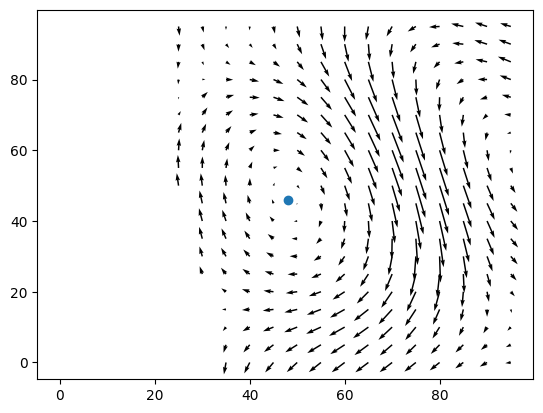

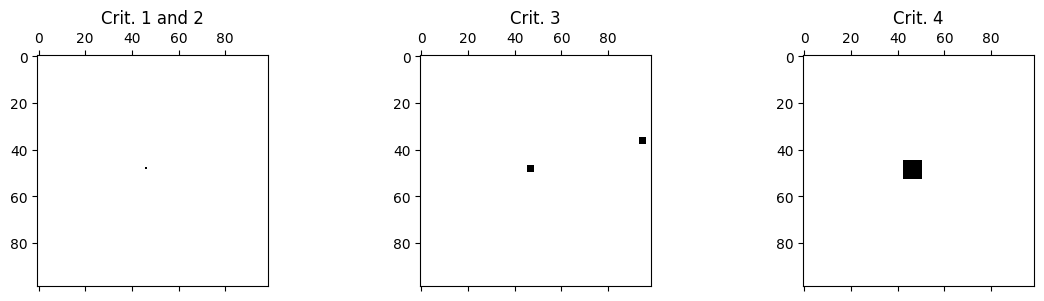

In [3]:
depth_lvl = 15
u, v = U[:,:,depth_lvl], V[:,:,depth_lvl]
a, b = 4, 3
combined = np.logical_and.reduce((nenc_crit_1_2(u, v, a), nenc_crit_3(u, v, b), nenc_crit_4(u, v, a)))
ic, jc = np.where(combined)

x, y = np.arange(0, u.shape[0]), np.arange(0, u.shape[1])

spacing = 5
plt.quiver(x[::spacing], y[::spacing], U[::spacing,::spacing,depth_lvl].T,V[::spacing,::spacing,depth_lvl].T)
plt.scatter(ic, jc)

fig, axs = plt.subplots(1, 3, figsize=(14,3))

axs[0].spy(nenc_crit_1_2(u, v, a))
axs[0].set_title('Crit. 1 and 2')
axs[1].spy(nenc_crit_3(u, v, b))
axs[1].set_title('Crit. 3')
axs[2].spy(nenc_crit_4(u, v, a))
axs[2].set_title('Crit. 4')

In [23]:
def uv_search(u, v, lon, lat, mask, a, b):
    """
    Identify the points in the domain which satisfy the four velocity constraints for eddy detection.

    Parameters:
    - u, v: 2D velocity fields for u and v components
    - lon, lat: Longitude and Latitude matrices
    - mask: Matrix defining sea (1) and land points (0)
    - a, b: Parameters used for constraints
    - periodic: If True, periodic boundary conditions are applied.

    Returns:
    - eddy_uv: Positions that satisfy the first two constraints (for debugging)
    - eddy_c: Positions satisfying the first three constraints (for debugging)
    - eddy: Positions of the eddy centers with their type (cyclonic=1, anticyclonic=-1)
    """
    # Mask land points
    v[mask == 0] = np.nan
    u[mask == 0] = np.nan

    borders = max(a, b) + 1

    # Compute velocity magnitude
    vel = np.sqrt(u**2 + v**2)

    # Initialize arrays for storing eddy centers
    eddy_uv = np.zeros((0, 2))
    eddy_c = np.zeros((0, 2))
    eddy = np.zeros((0, 3))

    # Get domain dimensions
    bound = vel.shape

    # Loop through each latitudinal section
    for i in range(borders, len(v) - borders + 1):
        wrk = v[i, :]  # Latitudinal section of v

        # First constraint: zero crossing in v component
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        indx = indx[(indx >= borders) & (indx < len(wrk) - borders)]

        for ii in indx:
            var = 0  # Eddy type (0 = no eddy, 1 = cyclonic, -1 = anticyclonic)
            if wrk[ii] >= 0:  # Anticyclonic
                if wrk[ii - a] > wrk[ii] and wrk[ii + 1 + a] < wrk[ii + 1]:
                    var = -1
            elif wrk[ii] < 0:  # Cyclonic
                if wrk[ii - a] < wrk[ii] and wrk[ii + 1 + a] > wrk[ii + 1]:
                    var = 1

            # Second constraint: u component reversal
            if var != 0:
                if var == -1:
                    if (u[i - a, ii] <= 0 and u[i - a, ii] <= u[i - 1, ii] and
                        u[i + a, ii] >= 0 and u[i + a, ii] >= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0
                elif var == 1:
                    if (u[i - a, ii] >= 0 and u[i - a, ii] >= u[i - 1, ii] and
                        u[i + a, ii] <= 0 and u[i + a, ii] <= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0

                # Third constraint: velocity minimum
                if var != 0:
                    srch = vel[i - b:i + b, ii - b:ii + b + 1]
                    slat = lat[i - b:i + b, ii - b:ii + b + 1]
                    slon = lon[i - b:i + b, ii - b:ii + b + 1]
                    X, Y = np.unravel_index(np.argmin(srch), srch.shape)
                    srch2 = vel[max(i - b + X - 1 - b, 0):min(i - b + X - 1 + b, bound[0]),
                                max(ii - b + Y - 1 - b, 0):min(ii - b + Y - 1 + b, bound[1])]

                    if np.min(srch2) == np.min(srch):
                        eddy_c = np.vstack([eddy_c, [slat[X, Y], slon[X, Y]]])
                    else:
                        var = 0

                # Fourth constraint: vector rotation (simplified version)
                d = a - 1
                if var != 0:
                    # Find indices of the estimated center in the large domain
                    i1, i2 = np.where((lat == slat[X, Y]) & (lon == slon[X, Y]))

                    i1, i2 = int(i1[0]), int(i2[0])
                    
                    # Extract velocities within "a-1" points from the estimated center
                    u_small = u[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    v_small = v[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    
                    # Apply constraint only if there are no NaNs in u_small
                    if not np.isnan(u_small).any():
                        # Boundary velocities
                        u_bound = np.concatenate([u_small[0, :], u_small[1:, -1], u_small[-1, -2::-1], u_small[-2::-1, 0]])
                        v_bound = np.concatenate([v_small[0, :], v_small[1:, -1], v_small[-1, -2::-1], v_small[-2::-1, 0]])

                        # Vector defining which quadrant each boundary vector belongs to
                        quadrants = np.zeros_like(u_bound)
                        quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
                        quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
                        quadrants[(u_bound < 0) & (v_bound < 0)] = 3
                        quadrants[(u_bound >= 0) & (v_bound < 0)] = 4
                        
                        # Identify the first fourth quadrant vector
                        spin = np.where(quadrants == 4)[0]
                        
                        # Apply the constraint only if the rotation is complete and not all vectors are in the fourth quadrant
                        if spin.size > 0 and spin.size != quadrants.size:
                            # If vectors start in the 4th quadrant, add 4 to all quadrant positions after the first occurrence
                            if spin[0] == 0:
                                spin = np.where(quadrants != 4)[0]
                                spin = spin[0] - 1
                            def process_spin(spin):
                                if isinstance(spin, list):
                                    return spin[-1]
                                return spin 
                            quadrants[process_spin(spin) + 1:] += 4
                            
                            # Inspect vector rotation: no consecutive vectors should be more than one quadrant apart
                            # and there should be no backward rotation
                            if not np.any(np.diff(quadrants) > 1) and not np.any(np.diff(quadrants) < 0):
                                eddy = np.vstack([eddy, [slat[X, Y], slon[X, Y], var]])


    # Process eddy results (sorting and removing duplicates)
    eddy = np.unique(eddy, axis=0)
    eddy_uv = np.unique(eddy_uv, axis=0)
    eddy_c = np.unique(eddy_c, axis=0)

    # Adjust for the Southern Hemisphere (flip cyclonic/anticyclonic labels)
    # eddy[eddy[:, 0] < 0, 2] = -eddy[eddy[:, 0] < 0, 2]
    eddy[:, 2] = -eddy[:, 2]

    return eddy_uv, eddy_c, eddy


In [6]:
with open('/srv/scratch/z5297792/Sample/sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
sample_data.keys()

dict_keys(['Eddy8', 'Eddy9', 'Eddy22', 'Eddy32', 'Eddy60', 'Eddy110', 'Eddy117', 'Eddy124', 'Eddy133', 'Eddy134', 'Eddy141', 'Eddy142', 'Eddy149', 'Eddy151', 'Eddy161', 'Eddy171'])

eddy_uv
[[-24000.  -3000.]
 [-24000.      0.]
 [-21000.  -3000.]
 [-21000.      0.]
 [-18000.  -3000.]
 [-18000.      0.]
 [-15000.  -3000.]
 [-15000.      0.]
 [-12000.  -3000.]
 [-12000.      0.]
 [ -9000.  -3000.]
 [ -9000.      0.]
 [ -6000.  -6000.]
 [ -6000.  -3000.]
 [ -3000.  -6000.]
 [ -3000.  -3000.]]
eddy_c
[[-12000.  -3000.]]
eddy
[[-1.2e+04 -3.0e+03 -1.0e+00]]


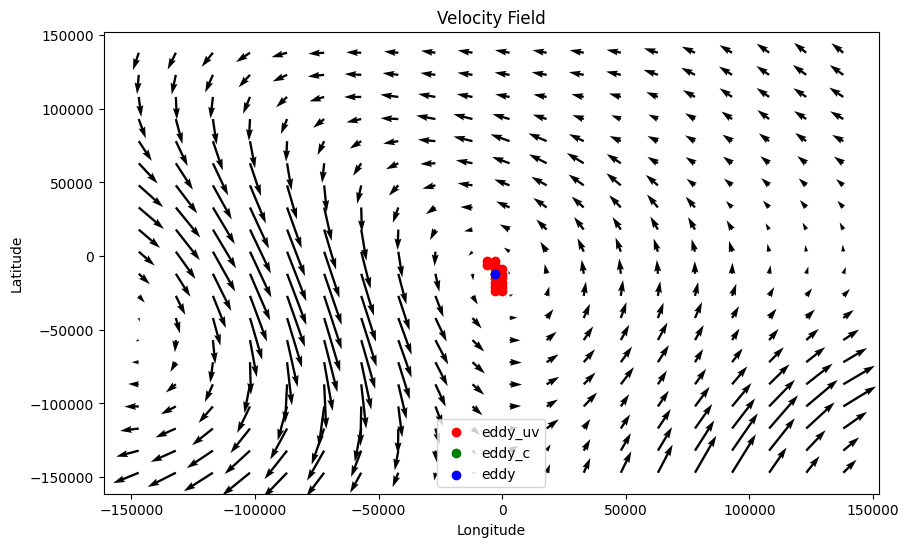

In [24]:
import numpy as np

eddy = 'Eddy110'
t = 10
depth_lvl = 5

U = sample_data[eddy]['T'+str(t)]['U']
V = sample_data[eddy]['T'+str(t)]['V']


u, v = U[:,:,depth_lvl], V[:,:,depth_lvl]

# Assuming `u` is a 2D array representing the velocity or data array
# lon = np.linspace(150, 152, u.shape[1])  # Longitude grid
# lat = np.linspace(-40, -38, u.shape[0])  # Latitude grid

lon = sample_data[eddy]['T'+str(t)]['x']  
lat = sample_data[eddy]['T'+str(t)]['y']

lon, lat = np.meshgrid(lon, lat)  # Create meshgrid


mask = np.ones(u.shape)  # Creating a mask with ones

a = 4  # Parameter a
b = 3  # Parameter b

eddy_uv, eddy_c, eddy = uv_search(u.T, v.T, lon, lat, mask, a, b)

print('eddy_uv')
print(eddy_uv)
print('eddy_c')
print(eddy_c) 
print('eddy')
print(eddy)


import numpy as np
import matplotlib.pyplot as plt

# Assuming `u`, `v`, `lon`, `lat` are already defined as arrays
spacing = 5  # Vector spacing

# Plotting the quiver plot
plt.figure(figsize=(10, 6))
plt.quiver(lon[::spacing, ::spacing], lat[::spacing, ::spacing], 
           u[::spacing, ::spacing].T, v[::spacing, ::spacing].T)


# Plot eddy_uv in red
plt.scatter(eddy_uv[:, 1], eddy_uv[:, 0], color='r', label='eddy_uv')

# Plot eddy_c in green
plt.scatter(eddy_c[:, 1], eddy_c[:, 0], color='g', label='eddy_c')

# Plot eddy in blue
plt.scatter(eddy[:, 1], eddy[:, 0], color='b', label='eddy')



plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Velocity Field')

plt.show()